An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


w0_ref is [0.19634954 0.19634954 0.39269908]
v0_ref is [2.75 2.75 2.25]
The goal configuration is 
[[ 0.70710678 -0.70710678  0.         10.        ]
 [ 0.70710678  0.70710678  0.         10.        ]
 [ 0.          0.          1.         10.        ]
 [ 0.          0.          0.          1.        ]]
Start Iteration: 0 , Used Time: 4.1000021155923605e-05
Iteration 0 start reference update,  Used Time: 13.137707260029856
Iteration 0 dynamics reinitialization finished, Used Time: 14.940207811014261
Iteration 0 cost reinitialization finished, Used Time: 17.886966405028943
Iteration:0, accepted, changed, grad_wrt_input_norm:2.276311438990413, cost:47997281.03864495, alpha:1.0, mu:0.5
Start Iteration: 1 , Used Time: 17.888438105001114
Iteration 1 start reference update,  Used Time: 29.26281205198029
Iteration 1 dynamics reinitialization finished, Used Time: 29.79490103997523
Iteration 1 cost reinitialization finished, Used Time: 33.341326766007114
Iteration:1, converged, changed, grad_wrt

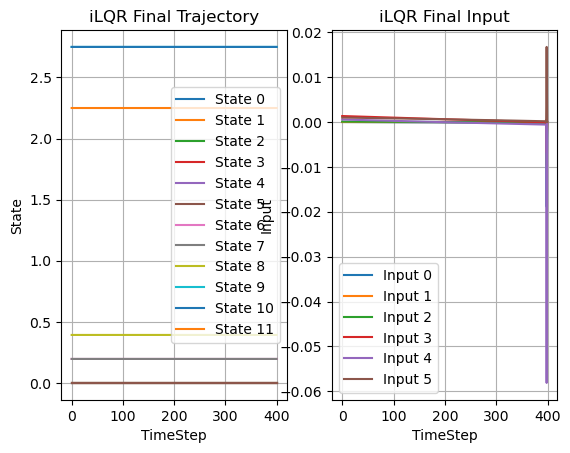

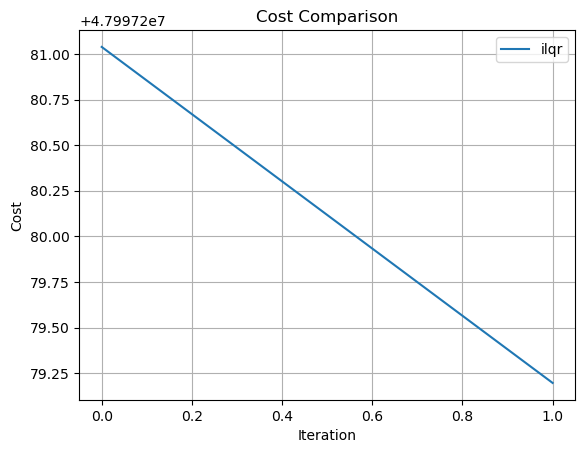

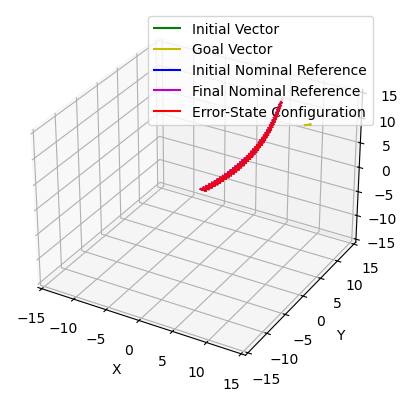

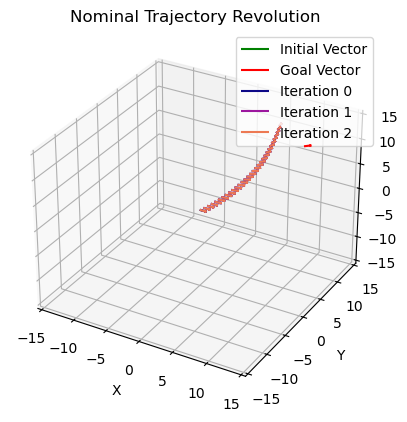

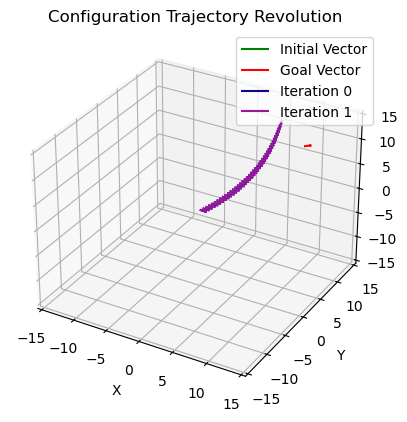

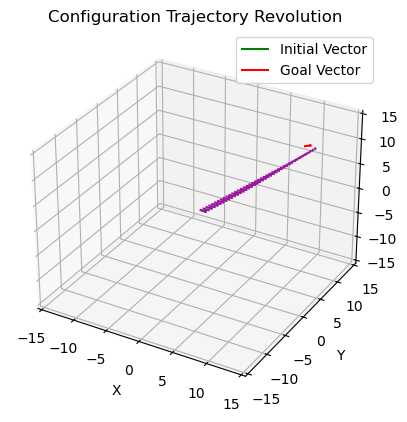

In [1]:
from traoptlibrary.traopt_controller import iLQR, iLQR_ErrorState_LinearRollout
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
from traoptlibrary.traopt_dynamics import ErrorStateSE3LinearRolloutAutoDiffDynamics, ErrorStateSE3NonlinearRolloutAutoDiffDynamics
from traoptlibrary.traopt_cost import ErrorStateSE3TrackingQuadratic2ndOrderAutodiffCost, AutoDiffCost
from traoptlibrary.traopt_cost import ErrorStateSE3GenerationQuadratic1stOrderAutodiffCost
from traoptlibrary.traopt_utilis import skew, unskew, se3_hat, se3_vee, quatpos2SE3, euler2quat, quat2rotm
from scipy.linalg import expm, logm
from pyquaternion import Quaternion
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

def on_iteration(iteration_count, xs, us, J_opt, Xref,
                accepted, converged, changed, grad_wrt_input_norm,
                alpha, mu, J_hist, 
                xs_hist, us_hist, Xref_hist):
    J_hist.append(J_opt)
    xs_hist.append(xs.copy())
    us_hist.append(us.copy())
    Xref_hist.append(Xref.copy())
    info = "converged" if converged else ("accepted" if accepted else "failed")
    info_change = "changed" if changed else "unchanged"

    print(f"Iteration:{iteration_count}, {info}, {info_change}, grad_wrt_input_norm:{grad_wrt_input_norm}, cost:{J_opt}, alpha:{alpha}, mu:{mu}")

seed = 24234156
key = random.key(seed)
jax.config.update("jax_enable_x64", True)

dt = 0.01
Nsim = 400   # Simulation horizon

# ====================
# Inertia Matrix
# ====================

m = 1
Ib = np.diag([ 0.5,0.7,0.9 ])
J = np.block([
    [Ib, np.zeros((3, 3))],
    [np.zeros((3, 3)), m * np.identity(3)]
])

# ========================================
# Goal Configuration For Trajecotory Generation
# ========================================

# [roll, pitch, yaw] angles in radians, 
# Yaw-pitch-roll rotation order (ZYX convention)
euler_goal = [0.,  0., jnp.pi / 4]
quat_goal = euler2quat(euler_goal) 

pos_goal = np.array([ 10., 10., 10. ])
q_goal = quatpos2SE3( np.concatenate((quat_goal, pos_goal)) )

# =====================================================
# Nominal Reference Generation
# =====================================================

q0_ref = np.array([1, 0, 0, 0])
p0_ref = np.array([0, 0, 0])

euler_devia = np.array([np.pi/4,np.pi/4,np.pi/4])
w0_ref = ( euler_goal + euler_devia )  / (Nsim * dt)
print("w0_ref is", w0_ref)

pos_devia = np.array([1,1,-1])
v0_ref = (pos_goal + pos_devia) / (Nsim * dt)
print("v0_ref is", v0_ref)

x0_ref = np.concatenate((q0_ref, p0_ref))
X0_ref = np.block([
    [ Quaternion(q0_ref).rotation_matrix, p0_ref.reshape(-1,1) ],
    [ np.zeros((1,3)),1 ],
])
X = X0_ref.copy()

xid_ref = np.concatenate((w0_ref, v0_ref))

X_ref = np.zeros((Nsim + 1, 7, 1))  # 7 because of [quat(4) + position(3)]
xi_ref = np.zeros((Nsim + 1, 6, 1)) 

X_ref[0] = x0_ref.reshape(7,1)
xi_ref[0] = xid_ref.reshape(6,1)

for i in range(Nsim):

    xid_ref_rt = xid_ref.copy()

    # You can try some time-varying twists here:
    # xid_ref_rt[0] = np.sin(i / 20) * 2
    # xid_ref_rt[4] = np.cos(np.sqrt(i)) * 1
    # xid_ref_rt[5] = 1  # np.sin(np.sqrt(i)) * 1

    Xi = se3_hat(xid_ref_rt)

    X = X @ expm(Xi * dt)

    # Extract rotation matrix and position vector
    rot_matrix = X[:3, :3]
    position = X[:3, 3]

    # Convert rotation matrix to quaternion
    quaternion = Quaternion(matrix=rot_matrix)
    quat = quaternion.elements

    # Store the reference trajectory (quaternion + position)
    X_ref[i + 1] = np.concatenate((quat, position)).reshape(7,1)

    # Store the reference twists
    xi_ref[i + 1] = xid_ref_rt.reshape(6,1)

X_ref = jnp.array(X_ref)
xi_ref = jnp.array(xi_ref)

# =====================================================
# Setup
# =====================================================

N = Nsim
HESSIANS = False
action_size = 6
state_size = 12
debug_dyn = {"vel_zero": False}

# =====================================================
# Dynamics Instantiation
# =====================================================

dynamics = ErrorStateSE3LinearRolloutAutoDiffDynamics(J, X_ref, xi_ref, dt, hessians=HESSIANS, debug=debug_dyn)

# =====================================================
# Cost Instantiation
# =====================================================

Q = np.identity(6) * 1e3
P = np.identity(6) * 1e5
R = np.identity(6) * 1e3

cost = ErrorStateSE3GenerationQuadratic1stOrderAutodiffCost( Q,R,P, X_ref, q_goal)

# =====================================================
# Solver Instantiation
# =====================================================

us_init = np.zeros((N, action_size,))

ilqr = iLQR_ErrorState_LinearRollout(dynamics, cost, N, 
                       hessians=HESSIANS, tracking=False)

xs_ilqr, us_ilqr, J_hist_ilqr, xs_hist_ilqr, us_hist_ilqr, Xref_hist_ilqr = \
        ilqr.fit(np.zeros((12,1)), us_init, n_iterations=200, tol_J=1e-8, on_iteration=on_iteration)


# =====================================================
# Visualization by State
# =====================================================

fig1 = plt.figure(1)
ax1 = fig1.add_subplot(121)
ax2 = fig1.add_subplot(122)

for j in range( state_size ):
    ax1.plot( xs_ilqr[:,j], label = 'State '+str(j) )
ax1.set_title('iLQR Final Trajectory')
ax1.set_xlabel('TimeStep')
ax1.set_ylabel('State')
ax1.legend()
ax1.grid()

for j in range( action_size ):
    ax2.plot( us_ilqr[:,j], label = 'Input '+str(j) )
ax2.set_title('iLQR Final Input')
ax2.set_xlabel('TimeStep')
ax2.set_ylabel('Input')
ax2.legend()
ax2.grid()

plt.figure(2)
plt.plot(J_hist_ilqr, label='ilqr')
plt.title('Cost Comparison')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend()
plt.grid()


# =====================================================
# Final Result Visualization with Vector
# =====================================================

interval_plot = int((Nsim + 1) / 40)
lim = 15

# Initialize the plot
fig1 = plt.figure(3)
ax1 = fig1.add_subplot(111, projection='3d')

# Define an initial vector and plot on figure
initial_vector = np.array([1, 0, 0])  # Example initial vector
ax1.quiver(0, 0, 0, initial_vector[0], initial_vector[1], initial_vector[2], 
           color='g', label='Initial Vector')
goal_vector = quat2rotm( quat_goal ) @ initial_vector
ax1.quiver(pos_goal[0], pos_goal[1], pos_goal[2], 
           goal_vector[0], goal_vector[1], goal_vector[2], 
           color='y', label='Goal Vector')


# Loop through quaternion data to plot rotated vectors
for i in range(0, Nsim + 1, interval_plot):  

    # =========== 1. Plot the first nominal trajectory ===========

    rot_matrix = quat2rotm(X_ref[i, :4, 0])  # Get the rotation matrix from the quaternion
    rotated_vector = rot_matrix @ initial_vector  # Apply the rotation to the initial vector
    
    # Extract the position 
    position = X_ref[i, 4:, 0]

    # Plot the rotated vector
    ax1.quiver(position[0], position[1], position[2],
              rotated_vector[0], rotated_vector[1], rotated_vector[2],
              color='b', length=1, label='Initial Nominal Reference' if i == 0 else '')
    
    # =========== 2. Plot the final nominal trajectory ===========

    rot_matrix = quat2rotm(Xref_hist_ilqr[-1, i, :4, 0])  # Extract the quaternion from the X_ref data
    rotated_vector = rot_matrix @ initial_vector  # Apply the rotation to the initial vector
    
    # Extract the position 
    position = Xref_hist_ilqr[-1, i, 4:, 0]

    # Plot the rotated vector
    ax1.quiver(position[0], position[1], position[2],
              rotated_vector[0], rotated_vector[1], rotated_vector[2],
              color='m', length=1, label='Final Nominal Reference' if i == 0 else '')
    
    # =========== 3. Plot the simulated error-state configuration trajectory ===========

    se3_matrix = quatpos2SE3( Xref_hist_ilqr[-1, i, :, 0] ) @ expm( se3_hat( xs_ilqr[i, :6]) )
    
    rot_matrix = se3_matrix[:3,:3]  # Get the rotation matrix from the quaternion
    rotated_vector = rot_matrix @ initial_vector  # Apply the rotation to the initial vector

    position = se3_matrix[:3, 3]
    
    # Plot the rotated vector
    ax1.quiver(position[0], position[1], position[2],
              rotated_vector[0], rotated_vector[1], rotated_vector[2],
              color='r', length=1, label='Error-State Configuration' if i == 0 else '')


# Set the limits for the axes

ax1.set_xlim([-lim, lim]) 
ax1.set_ylim([-lim, lim])
ax1.set_zlim([-lim, lim])
ax1.legend()
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# =====================================================
# Nominal Reference Evolution Visualization with Vector
# =====================================================

fig1 = plt.figure(4)
ax1 = fig1.add_subplot(111, projection='3d')

interval_plot = int((Nsim + 1) / 30)
lim = 15

# Define an initial vector and plot on figure
initial_vector = np.array([1, 0, 0])  # Example initial vector
ax1.quiver(0, 0, 0, initial_vector[0], initial_vector[1], initial_vector[2], 
           color='g', label='Initial Vector')
goal_vector = quat2rotm( quat_goal ) @ initial_vector
ax1.quiver(pos_goal[0], pos_goal[1], pos_goal[2], 
           goal_vector[0], goal_vector[1], goal_vector[2], 
           color='r', label='Goal Vector')

# Normalize to create a color map for Xref curves
norm = Normalize(vmin=0, vmax=Xref_hist_ilqr.shape[0] * 1)  # Adjust the normalization range for more difference
cmap = plt.colormaps['plasma']  # Choose a colormap with more contrast

# Loop through quaternion data to plot rotated vectors
for i in range( Xref_hist_ilqr.shape[0] ):
    color = cmap(norm(i)) 
    for j in range(0, Nsim + 1, interval_plot):  
        quat = Quaternion(Xref_hist_ilqr[i, j, :4, 0])  # Extract the quaternion from the X_ref data
        rot_matrix = quat.rotation_matrix  # Get the rotation matrix from the quaternion
        rotated_vector = rot_matrix @ initial_vector  # Apply the rotation to the initial vector
        
        # Extract the position 
        position = Xref_hist_ilqr[i, j, 4:, 0]

        # Plot the rotated vector
        ax1.quiver(position[0], position[1], position[2],
                rotated_vector[0], rotated_vector[1], rotated_vector[2],
                color=color, length=1, label='Iteration '+str(i) if j == 0 else '')
    

# Set the limits for the axes

ax1.set_title('Nominal Trajectory Revolution')
ax1.set_xlim([-lim, lim]) 
ax1.set_ylim([-lim, lim])
ax1.set_zlim([-lim, lim])
ax1.legend()
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')


# =====================================================
# Configuration Trajectory Evolution Visualization with Vector
# =====================================================

fig1 = plt.figure(5)
ax1 = fig1.add_subplot(111, projection='3d')

interval_plot = int((Nsim + 1) / 40)
lim = 15

# Define an initial vector and plot on figure
initial_vector = np.array([1, 0, 0])  # Example initial vector
ax1.quiver(0, 0, 0, initial_vector[0], initial_vector[1], initial_vector[2], 
           color='g', label='Initial Vector')
goal_vector = quat2rotm( quat_goal ) @ initial_vector
ax1.quiver(pos_goal[0], pos_goal[1], pos_goal[2], 
           goal_vector[0], goal_vector[1], goal_vector[2], 
           color='r', label='Goal Vector')

# Normalize to create a color map for Xref curves
norm = Normalize(vmin=0, vmax=Xref_hist_ilqr.shape[0] * 1)  # Adjust the normalization range for more difference
cmap = plt.colormaps['plasma']  # Choose a colormap with more contrast

# Loop through quaternion data to plot rotated vectors
for i in range( Xref_hist_ilqr.shape[0]-1 ):
    color = cmap(norm(i)) 
    for j in range(0, Nsim + 1, interval_plot):  

        se3_matrix = quatpos2SE3( Xref_hist_ilqr[i, j, :, 0] ) @ expm( se3_hat( xs_hist_ilqr[i+1, j, :6]) )

        rot_matrix = se3_matrix[:3,:3]
        rotated_vector = rot_matrix @ initial_vector  # Apply the rotation to the initial vector
        
        # Extract the position 
        position = se3_matrix[:3, 3]

        # Plot the rotated vector
        ax1.quiver(position[0], position[1], position[2],
                rotated_vector[0], rotated_vector[1], rotated_vector[2],
                color=color, length=1, label='Iteration '+str(i) if j == 0 else '')
    

# Set the limits for the axes

ax1.set_title('Configuration Trajectory Revolution')

ax1.set_xlim([-lim, lim]) 
ax1.set_ylim([-lim, lim])
ax1.set_zlim([-lim, lim])
ax1.legend()
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# =====================================================
# Nonlinear Rollout
# =====================================================

fig1 = plt.figure(6)
ax1 = fig1.add_subplot(111, projection='3d')

interval_plot = int((Nsim + 1) / 40)
lim = 15

nonlinear_dynamics = ErrorStateSE3NonlinearRolloutAutoDiffDynamics(J, us_ilqr, X0_ref, 
                                                         xid_ref, dt, hessians=HESSIANS, 
                                                         debug=debug_dyn)

# Define an initial vector and plot on figure
initial_vector = np.array([1, 0, 0])  # Example initial vector
ax1.quiver(0, 0, 0, initial_vector[0], initial_vector[1], initial_vector[2], 
           color='g', label='Initial Vector')
goal_vector = quat2rotm( quat_goal ) @ initial_vector
ax1.quiver(pos_goal[0], pos_goal[1], pos_goal[2], 
           goal_vector[0], goal_vector[1], goal_vector[2], 
           color='r', label='Goal Vector')

# Normalize to create a color map for Xref curves
norm = Normalize(vmin=0, vmax=Xref_hist_ilqr.shape[0] * 1)  # Adjust the normalization range for more difference
cmap = plt.colormaps['plasma']  # Choose a colormap with more contrast

# Loop through quaternion data to plot rotated vectors
for i in range(0, Nsim + 1, interval_plot):

    se3_matrix = nonlinear_dynamics.q_ref[i]

    rot_matrix = se3_matrix[:3,:3]
    rotated_vector = rot_matrix @ initial_vector  # Apply the rotation to the initial vector
    
    # Extract the position 
    position = se3_matrix[:3, 3]

    # Plot the rotated vector
    ax1.quiver(position[0], position[1], position[2],
            rotated_vector[0], rotated_vector[1], rotated_vector[2],
            color=color, length=1, label='Iteration '+str(i) if j == 0 else '')
    

# Set the limits for the axes

ax1.set_title('Configuration Trajectory Revolution')

ax1.set_xlim([-lim, lim]) 
ax1.set_ylim([-lim, lim])
ax1.set_zlim([-lim, lim])
ax1.legend()
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')


# # =====================================================
# # Plotting
# # =====================================================

# Display the plot
plt.show()

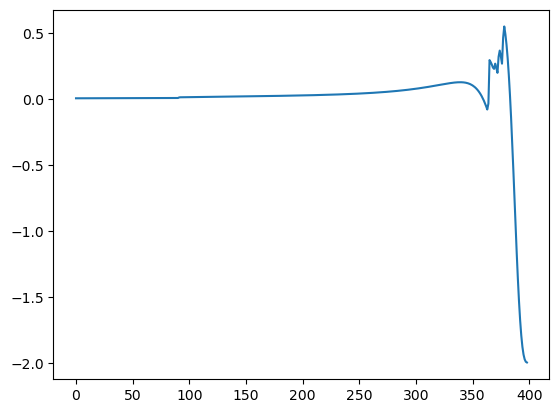

In [3]:
import numpy as np
import matplotlib.pyplot as plt

a = np.array([ 0.00331418,  0.00333529,  0.00335638,  0.00337747,  0.00339854,
        0.00341961,  0.00344067,  0.00346173,  0.00348279,  0.00350385,
        0.00352491,  0.00354598,  0.00356706,  0.00358816,  0.00360926,
        0.00363039,  0.00365154,  0.00367271,  0.00369391,  0.00371513,
        0.0037364 ,  0.0037577 ,  0.00377904,  0.00380043,  0.00382186,
        0.00384335,  0.0038649 ,  0.0038865 ,  0.00390817,  0.00392991,
        0.00395172,  0.00397361,  0.00399558,  0.00401763,  0.00403978,
        0.00406202,  0.00408436,  0.00410681,  0.00412937,  0.00415204,
        0.00417484,  0.00419775,  0.00422081,  0.00424399,  0.00426732,
        0.0042908 ,  0.00431442,  0.00433821,  0.00436216,  0.00438629,
        0.00441059,  0.00443507,  0.00445974,  0.0044846 ,  0.00450967,
        0.00453494,  0.00456043,  0.00458614,  0.00461208,  0.00463825,
        0.00466466,  0.00469132,  0.00471823,  0.0047454 ,  0.00477285,
        0.00480056,  0.00482857,  0.00485686,  0.00488545,  0.00491434,
        0.00494355,  0.00497308,  0.00500293,  0.00503312,  0.00506366,
        0.00509455,  0.00512579,  0.00515741,  0.00518939,  0.00522177,
        0.00525453,  0.0052877 ,  0.00532127,  0.00535526,  0.00538967,
        0.00542452,  0.00545982,  0.00549556,  0.00553176,  0.00556844,
        0.00560559,  0.00976108,  0.01096317,  0.01107701,  0.01119102,
        0.01130521,  0.01141956,  0.01153407,  0.01164873,  0.01176354,
        0.0118785 ,  0.01199359,  0.01210882,  0.01222417,  0.01233966,
        0.01245526,  0.01257098,  0.01268681,  0.01280276,  0.01291881,
        0.01303497,  0.01315124,  0.01326761,  0.01338408,  0.01350065,
        0.01361733,  0.0137341 ,  0.01385098,  0.01396796,  0.01408504,
        0.01420223,  0.01431953,  0.01443694,  0.01455445,  0.01467209,
        0.01478985,  0.01490773,  0.01502574,  0.01514388,  0.01526217,
        0.0153806 ,  0.01549919,  0.01561794,  0.01573686,  0.01585596,
        0.01597524,  0.01609472,  0.01621441,  0.01633432,  0.01645445,
        0.01657483,  0.01669546,  0.01681636,  0.01693753,  0.017059  ,
        0.01718078,  0.01730288,  0.01742533,  0.01754813,  0.01767131,
        0.01779488,  0.01791886,  0.01804327,  0.01816813,  0.01829347,
        0.0184193 ,  0.01854564,  0.01867252,  0.01879996,  0.01892799,
        0.01905663,  0.01918591,  0.01931585,  0.01944648,  0.01957782,
        0.01970992,  0.01984279,  0.01997646,  0.02011097,  0.02024636,
        0.02038264,  0.02051986,  0.02065804,  0.02079723,  0.02093746,
        0.02107877,  0.02122119,  0.02136477,  0.02150953,  0.02165553,
        0.0218028 ,  0.02195139,  0.02210134,  0.02225269,  0.02240549,
        0.02255978,  0.02271561,  0.02287303,  0.02303208,  0.02319283,
        0.02335531,  0.02351958,  0.0236857 ,  0.02385371,  0.02402368,
        0.02419565,  0.0243697 ,  0.02454587,  0.02472422,  0.02490483,
        0.02508775,  0.02527304,  0.02546077,  0.02565101,  0.02584382,
        0.02603928,  0.02623745,  0.02643841,  0.02664224,  0.026849  ,
        0.02705877,  0.02727163,  0.02748767,  0.02770696,  0.0279296 ,
        0.02815565,  0.02838521,  0.02861838,  0.02885523,  0.02909587,
        0.02934039,  0.02958888,  0.02984145,  0.03009819,  0.03035921,
        0.03062461,  0.03089451,  0.03116901,  0.03144823,  0.03173228,
        0.03202127,  0.03231534,  0.03261459,  0.03291917,  0.03322919,
        0.0335448 ,  0.03386611,  0.03419328,  0.03452645,  0.03486575,
        0.03521133,  0.03556335,  0.03592196,  0.03628732,  0.03665959,
        0.03703894,  0.03742553,  0.03781955,  0.03822116,  0.03863055,
        0.03904791,  0.03947342,  0.03990728,  0.0403497 ,  0.04080087,
        0.041261  ,  0.04173031,  0.04220902,  0.04269735,  0.04319553,
        0.04370379,  0.04422238,  0.04475154,  0.04529152,  0.04584258,
        0.04640498,  0.04697899,  0.04756487,  0.04816292,  0.04877341,
        0.04939664,  0.0500329 ,  0.0506825 ,  0.05134575,  0.05202295,
        0.05271444,  0.05342052,  0.05414154,  0.05487784,  0.05562974,
        0.05639759,  0.05718175,  0.05798256,  0.05880039,  0.05963558,
        0.0604885 ,  0.06135951,  0.06224897,  0.06315724,  0.06408468,
        0.06503164,  0.06599848,  0.06698553,  0.06799314,  0.06902162,
        0.07007129,  0.07114245,  0.07223537,  0.07335031,  0.07448749,
        0.07564712,  0.07682936,  0.07803433,  0.07926211,  0.08051272,
        0.08178613,  0.08308222,  0.08440083,  0.08574166,  0.08710434,
        0.0884884 ,  0.0898932 ,  0.09131799,  0.09276183,  0.09422363,
        0.09570207,  0.09719559,  0.0987024 ,  0.1002204 ,  0.10174716,
        0.10327989,  0.10481541,  0.10635006,  0.10787968,  0.10939953,
        0.11090425,  0.11238775,  0.11384316,  0.11526273,  0.11663771,
        0.11795827,  0.11921334,  0.12039051,  0.12147586,  0.12245379,
        0.12330685,  0.12401554,  0.1245581 ,  0.12491025,  0.12504496,
        0.12493218,  0.12453854,  0.12382702,  0.12275669,  0.12128229,
        0.11935399,  0.11691696,  0.11391111,  0.11027074,  0.10592432,
        0.10079427,  0.09479686,  0.08784224,  0.07983457,  0.0706725 ,
        0.06024977,  0.04845627,  0.03517943,  0.02030616,  0.0037254 ,
       -0.01466872, -0.03497288, -0.05726975, -0.08162231, -0.03629821,
        0.29273555,  0.27760019,  0.25879723,  0.23601656,  0.22631654,
        0.26574485,  0.23388655,  0.19628767,  0.31824206,  0.36500897,
        0.32041065,  0.26569209,  0.46218971,  0.54738672,  0.48798891,
        0.40832816,  0.30639398,  0.18092674,  0.03177546, -0.13976334,
       -0.3306966 , -0.53625612, -0.75005968, -0.96454416, -1.17164336,
       -1.36361709, -1.53388854, -1.67773499, -1.79271023, -1.87874477,
       -1.93794764, -1.97419515, -1.99258287, -1.99816037])
plt.plot(a)

In [6]:
np.array([[-1.95494592e-01, -4.28215664e-01,  4.58722028e-03,
         2.34288985e+00,  5.55204800e-01,  7.40082603e-01],
       [-1.98614014e-01, -4.27870689e-01,  5.38405596e-03,
         2.33993613e+00,  5.42156614e-01,  7.29913533e-01],
       [-2.01698222e-01, -4.27500267e-01,  6.16672514e-03,
         2.33701508e+00,  5.29108063e-01,  7.19755446e-01],
       ...,
       [-3.76904725e+00, -1.11607114e+00, -1.91425864e+00,
        -1.31877976e+00, -1.16320518e+01,  3.32427450e+00],
       [-1.88688819e+00, -5.58382448e-01, -9.58369603e-01,
        -6.85761741e-01, -5.81236007e+00,  1.67286378e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00]])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (7,) + inhomogeneous part.